In [1]:
# %%capture
!pip install transformers datasets


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [20]:
import functools
import itertools
import math
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from tabulate import tabulate
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import BertTokenizer

This is a template of the notebook that you should complete and enrich with your own code.

First cells will be the same than the ones of the lab on text convolution.

# Data loading


In [3]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


# Pre-processing / Tokenization

This is a very important step. It maybe boring but very important. In this session we will be lazy, but in real life, the time spent on inspecting and cleaning data is never wasted. It is true for text, but also for everything.



In PyTorch, everything is tensor. Words are replaced by indices. A sentence, is therefore a sequence of indices (long integers). In the first HW, you constructed a `WhiteSpaceTokenizer`. Here we will use an already built tokenizer. It is more appropriate to transformers. It relies on sub-word units, and converts everything in lower case. This is not always the best choice, but here it will be sufficient. To quote the documentation, this tokenizer allows you to:
- Tokenize (splitting strings in sub-word token strings), converttokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers).
- Add new tokens to the vocabulary in a way that is independent of the underlying structure (BPE, SentencePiece…).
- Manage special tokens (like mask, beginning-of-sentence, etc.): adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization.

Here we are going to use the tokenizer from the well known Bert model, that we can directly download.

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)


In [5]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x


Same celel than in the lab session.

🚧 **TODO** 🚧

Read the documentation about HuggingFace dataset and complete the code below.
You should:
- Shuffle the dataset
- For computational reasons, use only a total of **5000 samples**.
- Tokenize the dataset with the `preprocessing_fn`. (*Hint: use the `Dataset.map` method from HuggingFace*).
- Keep only columns `review_ids` and `label`.
- Make a train/validation split, (**80% / 20%**). Call these dataset `train_set` and `valid_set`.


In [6]:
n_samples = 5000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select 5000 samples
dataset = dataset.select(range(n_samples))

# Tokenize the dataset
dataset = dataset.map(lambda x: preprocessing_fn(x, tokenizer))

# Remove useless columns
dataset = dataset.remove_columns(["review", "sentiment"])

# Split the train and validation
dataset = dataset.train_test_split(test_size=0.2)

document_train_set = dataset["train"]
document_valid_set = dataset["test"]


Map: 100%|██████████| 5000/5000 [00:10<00:00, 469.39 examples/s]


In [92]:
## QUESTION 2
def extract_words_context(id_list: list[int], R: int):
  # if we are at the border we add some padding, assuming tokenizer.unk_token_id for the UNKNOWN token

  return (
    id_list,
    [
      [tokenizer.unk_token_id] * (R - (i - max(i - R, 0))) +
      id_list[max(i - R, 0):i] +
      id_list[(i + 1):min(i + R + 1, len(id_list))] +
      [tokenizer.unk_token_id] * (R - (min(i + R + 1, len(id_list)) - (i + 1)))
      for i in range(len(id_list))
    ]
  )

## QUESTION 3
def flatten_dataset_to_list(documentset,R):
  list_ids = []
  list_contexts = []
  for text in documentset["review_ids"]:
    new_ids, new_contexts = extract_words_context(text,R)
    list_ids += new_ids
    list_contexts += new_contexts
  return list_ids, list_contexts

## QUESTION 4
R = 10
flat_train = flatten_dataset_to_list(document_train_set, R)
flat_valid = flatten_dataset_to_list(document_valid_set, R)

print(len(flat_train))

2


In [94]:
from torch.utils.data import Dataset

In [95]:
##QUESTION 5
class idDataset(Dataset):
  def __init__(self, pair_of_list):
    self.list_ids = pair_of_list[0]
    self.list_contexts = pair_of_list[1]

  def __len__(self):
    return len(self.list_ids)
  def __getitem__(self, idx):
    return self.list_ids[idx], self.list_contexts[idx]

train_set = idDataset(flat_train)
valid_set = idDataset(flat_valid)
print(train_set[2])


(2023, [100, 100, 100, 100, 100, 100, 100, 100, 2006, 3666, 2143, 1010, 1045, 2001, 15261, 2012, 2129, 2865, 10617, 2064])


In [96]:
## QUESTION 6
def collate_fn(batch: list[tuple[int, list[int]]], *, K: int, R: int):
  return dict(
    word_id= torch.tensor([id for id, _ in batch]),
    positive_context_ids= torch.tensor([cont for _, cont in batch]),
    negative_context_ids= torch.randint(0, tokenizer.total_vocab_size, (len(batch), 2 * K * R)),
  )

## QUESTION 7
BATCH_SIZE = 100
K = 5
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, collate_fn=functools.partial(collate_fn, K=K, R=R))
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, collate_fn=functools.partial(collate_fn, K=K, R=R))

## QUESTION 8
print("K : ", K)
print("R : ", R)

for dic in itertools.islice(train_loader, 0, 3):
  print("word_id size : ", dic["word_id"].size())
  print("positive_context_id size : ", dic["positive_context_ids"].size())
  print("negative_context_ids size : ", dic["negative_context_ids"].size())

K :  5
R :  10
word_id size :  torch.Size([100])
positive_context_id size :  torch.Size([100, 20])
negative_context_ids size :  torch.Size([100, 100])
word_id size :  torch.Size([100])
positive_context_id size :  torch.Size([100, 20])
negative_context_ids size :  torch.Size([100, 100])
word_id size :  torch.Size([100])
positive_context_id size :  torch.Size([100, 20])
negative_context_ids size :  torch.Size([100, 100])


In [102]:
## QUESTION 9
class Word2Vec(nn.Module):
  def __init__(self, vocab_size: int, embedding_dim: int):
    super().__init__()

    self.word_embedding = nn.Embedding(vocab_size, embedding_dim)
    self.expand = nn.Linear(embedding_dim, vocab_size, bias=False)

  def forward(self, word_id: torch.Tensor):
    return self.word_embedding(word_id)

def sigma(x: torch.Tensor):
  return 1.0 / (1.0 + torch.exp(-x))


def save_model(model: Word2Vec, batch_index: int):
  with Path(f'model_dim-{EMBEDDING_DIM}_radius-{R}_ratio-{K}-batch-{batch_index}-epoch-{epoch}.ckpt').open('wb') as file:
    torch.save(model.state_dict(), file)


## QUESTION 10

EPOCH_COUNT = 10
EMBEDDING_DIM = 10

model = Word2Vec(tokenizer.total_vocab_size, EMBEDDING_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = torch.empty(EPOCH_COUNT)

for epoch in range(EPOCH_COUNT):
  epoch_loss = 0.0

  for batch in tqdm(train_loader):
    optimizer.zero_grad()

    # Size: (batch size, 1, embedding dim)
    word_embeddings = model(batch['word_id'])[:, None, :]

    # Size: (batch size, 2R, embedding dim)
    positive_embeddings = model(batch['positive_context_ids'])

    # Size: (batch size, 2KR, embedding dim)
    negative_embeddings = model(batch['negative_context_ids'])

    loss = (-torch.log(sigma(word_embeddings * positive_embeddings)).mean(dim=1) - \
      torch.log(sigma(1.0 - word_embeddings * positive_embeddings)).mean(dim=1)).sum(dim=1).mean()

    loss.backward()
    optimizer.step()

    epoch_loss = loss.item() * batch['word_id'].size(0)

  losses[epoch] = epoch_loss / len(train_loader.dataset)

100%|██████████| 8211/8211 [00:17<00:00, 468.53it/s]


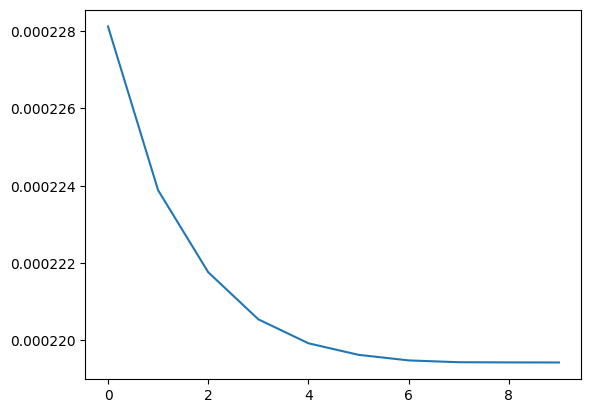

In [105]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.plot(losses);